# SNV Frequency Spectrum

**Author**: Katarina Braun 


## Overview
This notebook plots SNV frequency spectrums. It pulls SNVs and their frequencies from the `-cleaned.csv` files that were generated in the `data_cleaning.ipynb` script. 

### Reference 

Everything was mapped to the Japan reference sequence (MW219695.1) -- this is the consensus sequence for the inoculum that was used to infect the cats we are evaluating here. 

Nucleotide numbering scheme will therefore differ from the the numbering scheme used in Nextstrain. 

[Link](https://www.ncbi.nlm.nih.gov/nuccore/MW219695.1) to GenBank accession page for the reference sequence.

[Link](https://www.nejm.org/doi/full/10.1056/nejmc2013400) to the original NEJM report on transmission of SARS-CoV-2 in domestic cats by Halfmann et al. 

### A useful description regarding the interpretation of these analyses 
**From Moncla et al, 2019, bioRxiv (https://doi.org/10.1101/683151):**  
"Purifying selection removes new variants from the population, generating an excess of low-freq variants, while positive selection promotes accumulation of high-frequency polymorphisms. Exponential population expansion also causes excess low-frequency variation; however, while selection disproportionately affects nonsynonymous variants, demographic factors affect synonymous and nonsynonymous variants equally."

I will also try to derive the "neutral expectation" -- that is the distribution of SNPs expected for a given population assuming that the population is not under selection and is at some sort of steady-state equilibrium. 

For the neutral expectation, Trevor Bedford suggests this will follow a 1/x distribution. I can then just integrate over a 1/x distribution between each bin size (0.01 to 0.1, 0.1 to 0.2, etc...). Then I'll calculate the proportion of the total that fall into each bin. Dr. Louise Moncla (cited above) already prepared a notebook to do this: `neutral-expectation.ipynb`, which I am going to utilize here. 
    

## import modules and dependecies 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from itertools import cycle, islice
import random 
from pylab import *
from matplotlib.ticker import StrMethodFormatter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import csv
import sys, subprocess, glob, os, shutil, re, importlib, Bio
from subprocess import call
from Bio import SeqIO
from scipy import stats
from scipy.integrate import quad
import seaborn as sns
import os
import seaborn as sns; sns.set()
from matplotlib import pyplot
from functools import reduce
import matplotlib as mpl
from matplotlib import gridspec
import itertools
import pysam
import matplotlib.patches as mpatches
import random 
from pylab import *
from matplotlib.font_manager import FontProperties 
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.lines as mlines
from matplotlib import gridspec
import random

## Add in neutral expectation as a light grey bar

The neutral expectation code is from Dr. Louise Moncla (https://github.com/lmoncla). 

The expectation for the proportion of variants in each frequency bin is given by a 1/x distribution. I will integrate the area under the curve for a 1/x distribution between each interval and plot this expected value.

In [126]:
# define functions 

from scipy.integrate import quad

def integrate_over_bins(lower_bound,upper_bound):
    # generate lambda function for 1/x
    f= lambda x:(1/x)

    # integrate between bins 
    integral = quad(f, lower_bound, upper_bound)[0]
    return(integral)

def return_area_under_curve(bins):

    total_area_under_curve = 0
    integrals = []
    
    for i in range(len(bins)-1):
        lower_bound = bins[i]
        upper_bound = bins[i+1]
        integral = integrate_over_bins(lower_bound,upper_bound)
        integrals.append(integral)
        
    total_area_under_curve = np.asarray(integrals).sum()
    return(total_area_under_curve, integrals)

def return_neutral_expectation(total_area_under_curve, integrals):
    proportions = []
    for i in integrals: 
        proportion = i/total_area_under_curve
        proportions.append(proportion)
        
    return(proportions)

In [127]:
# predict neutral expectations for 10 bins 
bins = [0.03,0.1,0.2,0.3,0.4,0.5]
total_area_under_curve, integrals = return_area_under_curve(bins)
proportions = return_neutral_expectation(total_area_under_curve, integrals)
neutral_df = pd.DataFrame({"bin":["3-10%","10-20%","20-30%","30-40%","40-50%"],"expected":proportions})

neutral_df

print(neutral_df)

      bin  expected
0   3-10%  0.427941
1  10-20%  0.246373
2  20-30%  0.144119
3  30-40%  0.102254
4  40-50%  0.079314


## Define non-neutral functions 

In [138]:
def load_Illumina_SNVs(sample): 
    i = pd.read_csv('../data_derived/cleaned/' + sample + '-intersection.csv', sep='\t')
    # modify the dataframes to retain only SNP and frequency 
    # drop rows that are not SNPs
    i = i[~i.SNP.str.contains("frameshift")]
    i = i[~i.SNP.str.contains("disruptive-inframe-deletion")]
    # drop any rows with SNPs between 97 and 100% frequency because these = fixed 
    # i've already dropped all snvs ≤3% frequency in the data cleaning stage
    i = i[['SNP', '%']]
    i = i[~(i['%'] >= 0.97) & (i['%'] <= 1)]
    # sort SNPs by frequency 
    i = i.sort_values(by=['%'], ascending=False)
#     print(i)
    # drop the SNP column and keep frequency only, identity of the SNP doesn't matter for this 
    i = i[['%']]
    # determine the number of SNPs so I can determine proportions
    i_num_snps = len(i.index)
    print(i_num_snps)
    # count the number of SNPs within frequency bins 
    # bins: 3-10, 10-20, 20-30, 30-40, 40-50, 50-60, 60-70, 70-80, 80-90, 90-99
    i_SFS = i.apply(pd.Series.value_counts, bins=[0.03,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.97])
    # replace counts with proportions 
    i_SFS['proportion of SNVs'] = i_SFS['%'].div(i_num_snps)
    i_SFS = i_SFS[['proportion of SNVs']]
    i_SFS = i_SFS.sort_index(ascending=True)
    i_SFS_new = i_SFS.reset_index()
    i_SFS_new = i_SFS_new.rename(index={0:'3-10%', 1:'10-20%', 2:'20-30%', 3:'30-40%', 4:'40-50%', 5:'50-60%', 6:'60-70%', 7:'70-80%', 8:'80-90%', 9:'90-97%'})
    i_SFS_new = i_SFS_new[['proportion of SNVs']]
    i_SFS_new.rename(columns={'proportion of SNVs':'index'}, inplace=True)
    return(i_SFS_new)

In [139]:
# run the above function on all samples
df1_1 = load_Illumina_SNVs('1_1')
df1_2 = load_Illumina_SNVs('1_2')
df1_3 = load_Illumina_SNVs('1_3')
df1_4 = load_Illumina_SNVs('1_4')
df1_5 = load_Illumina_SNVs('1_5')
df1_6 = load_Illumina_SNVs('1_6')
df1_7 = load_Illumina_SNVs('1_7')
df1_8 = load_Illumina_SNVs('1_8')

df4_3 = load_Illumina_SNVs('4_3')
df4_4 = load_Illumina_SNVs('4_4')
df4_5 = load_Illumina_SNVs('4_5')
df4_6 = load_Illumina_SNVs('4_6')
df4_7 = load_Illumina_SNVs('4_7')
df4_8 = load_Illumina_SNVs('4_8')
df4_9 = load_Illumina_SNVs('4_9')
df4_10 = load_Illumina_SNVs('4_10')

#

2
2
5
4
4
5
4
2
1
1
1
1
2
3
0
1


In [208]:
# concatenate all dataframes 
df1 = pd.concat([df1_1, df1_2, df1_3, df1_4, df1_5, df1_6, df1_7, df1_8], axis=1)
df1 = df1.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df1['avg'] = df1.mean(axis=1)
df1['std'] = df1.std(axis=1)
df_avg1 = df1[['avg']]
df_std1 = df1[['std']]

# concatenate all dataframes 
df4 = pd.concat([df4_3, df4_4, df4_5, df4_6, df4_7, df4_8, df4_9, df4_10], axis=1)
df4 = df4.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df4['avg'] = df4.mean(axis=1)
df4['std'] = df4.std(axis=1)
df_avg4 = df4[['avg']]
df_std4 = df4[['std']]

# df1

#

## Generate SFS Plots

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


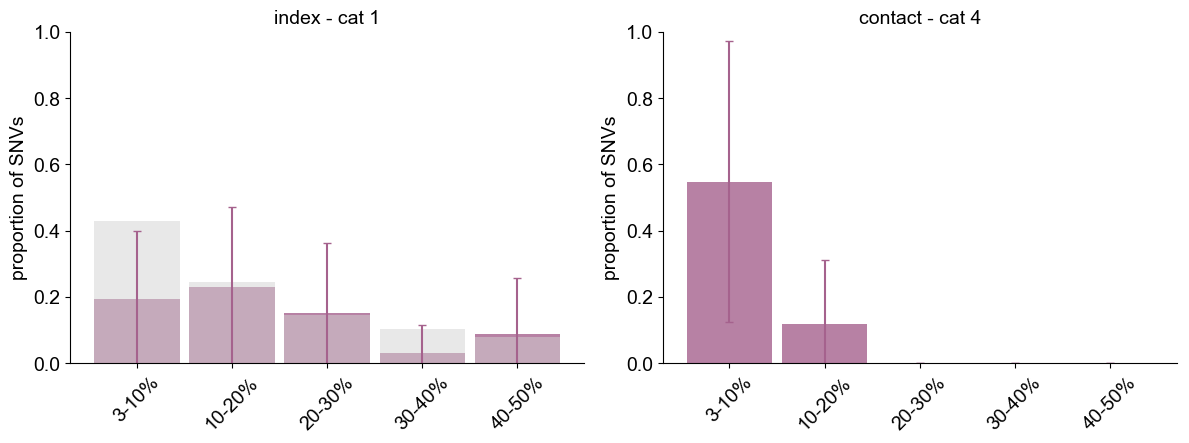

In [141]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig.add_subplot(gs[0,0:4]) # index
ax2 = fig.add_subplot(gs[0,4:8]) # contact

# get right of top and right frame of each subplot
axes = (ax1, ax2)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# primary_NP_swab_Illumina
df_avg1.plot(kind='bar', yerr=df_std1['std'], ecolor='#A5628D', capsize=3, grid=False, color='#A5628D', figsize=(12,8), width=0.9, alpha=0.8, ax=ax1, legend=False)
df_avg4.plot(kind='bar', yerr=df_std4['std'], ecolor='#A5628D', capsize=3, grid=False, color='#A5628D', figsize=(12,8), width=0.9, alpha=0.8, ax=ax2, legend=False)

ax1.set_title('index - cat 1', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax1.set_xlabel('', fontname='Arial', fontsize=14)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax2.set_title('contact - cat 4', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(0,1.0)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax2.set_xlabel('', fontname='Arial', fontsize=14)
ax2.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.5, ax=ax1, legend=False, label=None)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax1.set_xlabel("")
ax2.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/SFS_pair1.svg", bbox_inches='tight', dpi=300)

In [142]:
# run the above function on all samples
df2_1 = load_Illumina_SNVs('2_1')
df2_2 = load_Illumina_SNVs('2_2')
df2_3 = load_Illumina_SNVs('2_3')
df2_4 = load_Illumina_SNVs('2_4')
df2_5 = load_Illumina_SNVs('2_5')
df2_6 = load_Illumina_SNVs('2_6')
df2_7 = load_Illumina_SNVs('2_7')
df2_8 = load_Illumina_SNVs('2_8')

df5_3 = load_Illumina_SNVs('5_3')
df5_4 = load_Illumina_SNVs('5_4')
df5_5 = load_Illumina_SNVs('5_5')
df5_6 = load_Illumina_SNVs('5_6')
df5_7 = load_Illumina_SNVs('5_7')
df5_8 = load_Illumina_SNVs('5_8')
df5_9 = load_Illumina_SNVs('5_9')
df5_10 = load_Illumina_SNVs('5_10')

#

4
5
5
2
5
3
4
5
0
1
1
1
1
1
1
1


In [143]:
# concatenate all dataframes 
df2 = pd.concat([df2_1, df2_2, df2_3, df2_4, df2_5, df2_6, df2_7, df2_8], axis=1)
df2 = df2.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df2['avg'] = df2.mean(axis=1)
df2['std'] = df2.std(axis=1)
df_avg2 = df2[['avg']]
df_std2 = df2[['std']]

# concatenate all dataframes 
df5 = pd.concat([df5_3, df5_4, df5_5, df5_6, df5_7, df5_8, df5_9, df5_10], axis=1)
df5 = df5.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df5['avg'] = df5.mean(axis=1)
df5['std'] = df5.std(axis=1)
df_avg5 = df5[['avg']]
df_std5 = df5[['std']]

#

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


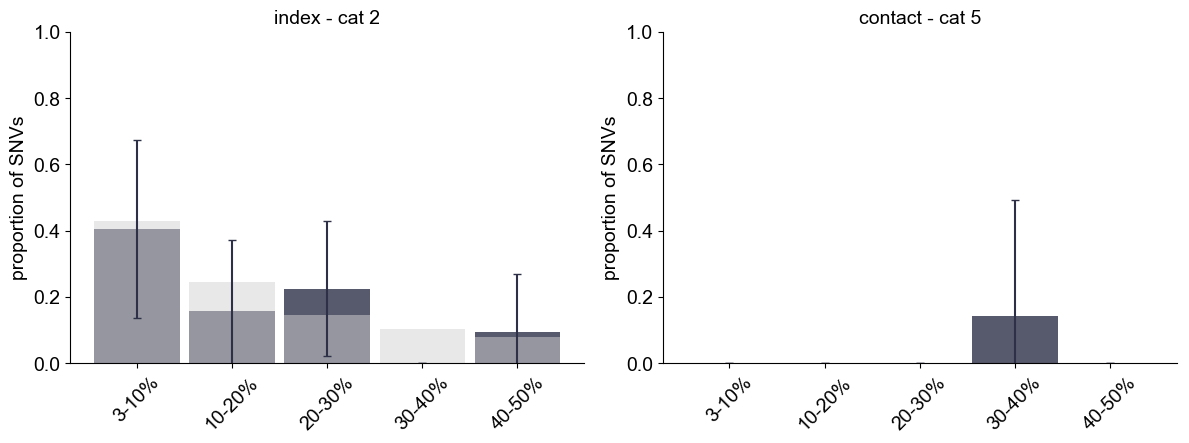

In [144]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig.add_subplot(gs[0,0:4]) # index
ax2 = fig.add_subplot(gs[0,4:8]) # contact

# get right of top and right frame of each subplot
axes = (ax1, ax2)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# primary_NP_swab_Illumina
df_avg2.plot(kind='bar', yerr=df_std2['std'], ecolor='#2D3047', capsize=3, grid=False, color='#2D3047', figsize=(12,8), width=0.9, alpha=0.8, ax=ax1, legend=False)
df_avg5.plot(kind='bar', yerr=df_std5['std'], ecolor='#2D3047', capsize=3, grid=False, color='#2D3047', figsize=(12,8), width=0.9, alpha=0.8, ax=ax2, legend=False)

ax1.set_title('index - cat 2', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax1.set_xlabel('', fontname='Arial', fontsize=14)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax2.set_title('contact - cat 5', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(0,1.0)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax2.set_xlabel('', fontname='Arial', fontsize=14)
ax2.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.5, ax=ax1, legend=False, label=None)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax1.set_xlabel("")
ax2.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/SFS_pair2.svg", bbox_inches='tight', dpi=300)

In [145]:
# run the above function on all samples
df3_1 = load_Illumina_SNVs('3_1')
df3_2 = load_Illumina_SNVs('3_2')
df3_3 = load_Illumina_SNVs('3_3')
df3_4 = load_Illumina_SNVs('3_4')
df3_5 = load_Illumina_SNVs('3_5')
# df3_6 = load_Illumina_SNVs('3_6')
df3_7 = load_Illumina_SNVs('3_7')
df3_8 = load_Illumina_SNVs('3_8')

# df6_3 = load_Illumina_SNVs('6_3')
df6_4 = load_Illumina_SNVs('6_4')
df6_5 = load_Illumina_SNVs('6_5')
df6_6 = load_Illumina_SNVs('6_6')
df6_7 = load_Illumina_SNVs('6_7')
df6_8 = load_Illumina_SNVs('6_8')
df6_9 = load_Illumina_SNVs('6_9')
df6_10 = load_Illumina_SNVs('6_10')

#

3
6
6
3
5
6
1
0
2
0
0
4
0
0


In [146]:
# concatenate all dataframes 
df3 = pd.concat([df3_1, df3_2, df3_3, df3_4, df3_5, df3_7, df3_8], axis=1)
df3 = df3.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df3['avg'] = df3.mean(axis=1)
df3['std'] = df3.std(axis=1)
df_avg3 = df3[['avg']]
df_std3 = df3[['std']]

# concatenate all dataframes 
df6 = pd.concat([df6_4, df6_5, df6_6, df6_7, df6_8, df6_9, df6_10], axis=1)
df6 = df6.loc[['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], :]

# find average and std dev across rows 
df6['avg'] = df6.mean(axis=1)
df6['std'] = df6.std(axis=1)
df_avg6 = df6[['avg']]
df_std6 = df6[['std']]

#

/Users/katbraun/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


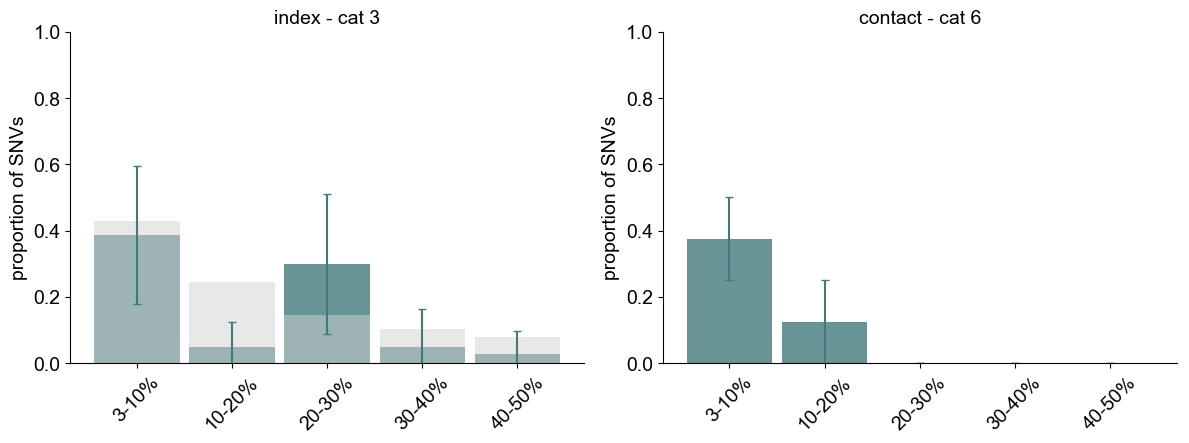

In [147]:
# generate a figure with sub-plots (one for each gene segment)
fig = plt.figure(figsize=(8,8), facecolor='w')
plt.style.use('default')
mpl.rc('font', family='Arial')
gs = gridspec.GridSpec(2, 8)

ax1 = fig.add_subplot(gs[0,0:4]) # index
ax2 = fig.add_subplot(gs[0,4:8]) # contact

# get right of top and right frame of each subplot
axes = (ax1, ax2)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    
# set fontsize of axes 
ax = plt.gca()
for ax in axes: 
    ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = 14)

# get right of top and right frame of each subplot
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(True)
ax1.spines['left'].set_visible(True)

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(True)
ax2.spines['left'].set_visible(True)

# primary_NP_swab_Illumina
df_avg3.plot(kind='bar', yerr=df_std3['std'], ecolor='#42797C', capsize=3, grid=False, color='#42797C', figsize=(12,8), width=0.9, alpha=0.8, ax=ax1, legend=False)
df_avg6.plot(kind='bar', yerr=df_std6['std'], ecolor='#42797C', capsize=3, grid=False, color='#42797C', figsize=(12,8), width=0.9, alpha=0.8, ax=ax2, legend=False)

ax1.set_title('index - cat 3', fontname='Arial', fontsize=14)
ax1.set_facecolor('white')
for tick in ax1.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax1.get_yticklabels():
    tick.set_fontname("Arial")
ax1.set_ylim(0,1.0)
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax1.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax1.set_xlabel('', fontname='Arial', fontsize=14)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax2.set_title('contact - cat 6', fontname='Arial', fontsize=14)
ax2.set_facecolor('white')
for tick in ax2.get_xticklabels():
    tick.set_fontname("Arial")
for tick in ax2.get_yticklabels():
    tick.set_fontname("Arial")
ax2.set_ylim(0,1.0)
ax2.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax2.set_ylabel('proportion of SNVs', fontname='Arial', fontsize=14)
ax2.set_xlabel('', fontname='Arial', fontsize=14)
ax2.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

# plot neutral expectation
neutral_df.plot(kind='bar', grid=False, color='lightgrey', figsize=(12,8), width=0.9, alpha=0.5, ax=ax1, legend=False, label=None)
ax1.set_xticklabels(['3-10%', '10-20%', '20-30%', '30-40%', '40-50%'], fontname='Arial', fontsize=14, minor=False, rotation=45)

ax1.set_xlabel("")
ax2.set_xlabel("")

# use tight_layout to optimize spacing of axes and titles within each subplot
fig.tight_layout()
fig.show()

# save this plot to the figures folder 
fig.savefig("../figures/SFS_pair3.svg", bbox_inches='tight', dpi=300)

# SFS tables - compare neutral expectation vs SFS in index cats

In [148]:
df1.columns = ['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8', 'avg', 'std']
df1

,DPI 1,DPI 2,DPI 3,DPI 4,DPI 5,DPI 6,DPI 7,DPI 8,avg,std
3-10%,0.0,0.0,0.4,0.50,0.25,0.4,0.00,0.0,0.19375,0.203773
10-20%,0.0,0.0,0.2,0.25,0.25,0.4,0.75,0.0,0.23125,0.239710
20-30%,0.5,0.5,0.0,0.00,0.00,0.2,0.00,0.0,0.15000,0.212132
30-40%,0.0,0.0,0.0,0.00,0.25,0.0,0.00,0.0,0.03125,0.082680
40-50%,0.5,0.0,0.2,0.00,0.00,0.0,0.00,0.0,0.08750,0.169097


In [149]:
df2.columns = ['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8', 'avg', 'std']
df2

,DPI 1,DPI 2,DPI 3,DPI 4,DPI 5,DPI 6,DPI 7,DPI 8,avg,std
3-10%,0.00,0.8,0.4,0.0,0.6,0.333333,0.5,0.6,0.404167,0.267933
10-20%,0.00,0.0,0.2,0.0,0.2,0.666667,0.0,0.2,0.158333,0.213275
20-30%,0.50,0.2,0.4,0.0,0.2,0.000000,0.5,0.0,0.225000,0.204634
30-40%,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
40-50%,0.25,0.0,0.0,0.5,0.0,0.000000,0.0,0.0,0.093750,0.173993


In [150]:
df3.columns = ['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 7', 'DPI 8', 'avg', 'std']
df3

,DPI 1,DPI 2,DPI 3,DPI 4,DPI 5,DPI 7,DPI 8,avg,std
3-10%,0.333333,0.500000,0.5,0.666667,0.2,0.500000,0.0,0.385714,0.208439
10-20%,0.000000,0.166667,0.0,0.000000,0.0,0.166667,0.0,0.047619,0.075292
20-30%,0.333333,0.333333,0.5,0.000000,0.6,0.333333,0.0,0.300000,0.211570
30-40%,0.333333,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.047619,0.116642
40-50%,0.000000,0.000000,0.0,0.000000,0.2,0.000000,0.0,0.028571,0.069985


In [151]:
neutral_df

,bin,expected
0,3-10%,0.427941
1,10-20%,0.246373
2,20-30%,0.144119
3,30-40%,0.102254
4,40-50%,0.079314


### Mann Whitney U test to compare differences in SNP frequencies between each index cats the neutral expectation

#### This seems like a better option than an unpaired t-test, because these data are not normally distributed 

The neutral expectation bins are outlined above.  

I am going to generate a comparator group by randomly generating x SNPs per bin where x = # of SNPs in the index cat * % SNPs expected to fall in that bin. I'll use a random number generator to generate the exact frequencies. Then I'll assign each of these series to a variable and compare these variables by Python stats Mann Whitney U package 


I'll compare each index cat seperately and then I'll also combine all three and compare the groups. 


In [152]:
cat1 = pd.read_csv('../data_derived/cleaned/cat1_snps_over_time.csv', sep='\t')
cat1 = cat1[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8']]
cat1 = cat1.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat1 = cat1.replace('', np.nan, regex=True)              
print(cat1.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat1_freqs_1 = cat1['DPI 1'].tolist()
cat1_freqs_2 = cat1['DPI 2'].tolist()
cat1_freqs_3 = cat1['DPI 3'].tolist()
cat1_freqs_4 = cat1['DPI 4'].tolist()
cat1_freqs_5 = cat1['DPI 5'].tolist()
cat1_freqs_6 = cat1['DPI 6'].tolist()
cat1_freqs_7 = cat1['DPI 7'].tolist()
cat1_freqs_8 = cat1['DPI 8'].tolist()
cat1_freqs = cat1_freqs_1 + cat1_freqs_2 + cat1_freqs_3 + cat1_freqs_4 + cat1_freqs_5 + cat1_freqs_6 + cat1_freqs_7 + cat1_freqs_8
cat1_freqs = [x for x in cat1_freqs if str(x) != 'nan']

# cat1_freqs
#

31


In [153]:
cat2 = pd.read_csv('../data_derived/cleaned/cat2_snps_over_time.csv', sep='\t')
cat2 = cat2[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8']]
cat2 = cat2.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat2 = cat2.replace('', np.nan, regex=True)              
print(cat2.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat2_freqs_1 = cat2['DPI 1'].tolist()
cat2_freqs_2 = cat2['DPI 2'].tolist()
cat2_freqs_3 = cat2['DPI 3'].tolist()
cat2_freqs_4 = cat2['DPI 4'].tolist()
cat2_freqs_5 = cat2['DPI 5'].tolist()
cat2_freqs_6 = cat2['DPI 6'].tolist()
cat2_freqs_7 = cat2['DPI 7'].tolist()
cat2_freqs_8 = cat2['DPI 8'].tolist()
cat2_freqs = cat2_freqs_1 + cat2_freqs_2 + cat2_freqs_3 + cat2_freqs_4 + cat2_freqs_5 + cat2_freqs_6 + cat2_freqs_7 + cat2_freqs_8
cat2_freqs = [x for x in cat2_freqs if str(x) != 'nan']

# cat2_freqs
#

41


In [154]:
cat3 = pd.read_csv('../data_derived/cleaned/cat3_snps_over_time.csv', sep='\t')
cat3 = cat3[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 7', 'DPI 8']]
cat3 = cat3.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat3 = cat3.replace('', np.nan, regex=True)              
print(cat3.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat3_freqs_1 = cat3['DPI 1'].tolist()
cat3_freqs_2 = cat3['DPI 2'].tolist()
cat3_freqs_3 = cat3['DPI 3'].tolist()
cat3_freqs_4 = cat3['DPI 4'].tolist()
cat3_freqs_5 = cat3['DPI 5'].tolist()
# cat3_freqs_6 = cat3['DPI 6'].tolist()
cat3_freqs_7 = cat3['DPI 7'].tolist()
cat3_freqs_8 = cat3['DPI 8'].tolist()
cat3_freqs = cat3_freqs_1 + cat3_freqs_2 + cat3_freqs_3 + cat3_freqs_4 + cat3_freqs_5 + cat3_freqs_7 + cat3_freqs_8
cat3_freqs = [x for x in cat3_freqs if str(x) != 'nan']

# cat3_freqs
#

37


In [155]:
# prep neutral df for each index cat

neutral_df['cat_1_expectation'] = neutral_df['expected'] * 31 
neutral_df['cat_2_expectation'] = neutral_df['expected'] * 41
neutral_df['cat_3_expectation'] = neutral_df['expected'] * 37

neutral_df['cat_1_expectation'] = neutral_df['cat_1_expectation'].round() # rounded to nearest integer
neutral_df['cat_2_expectation'] = neutral_df['cat_2_expectation'].round() # rounded to nearest integer
neutral_df['cat_3_expectation'] = neutral_df['cat_3_expectation'].round() # rounded to nearest integer

neutral_df

,bin,expected,cat_1_expectation,cat_2_expectation,cat_3_expectation
0,3-10%,0.427941,13.0,18.0,16.0
1,10-20%,0.246373,8.0,10.0,9.0
2,20-30%,0.144119,4.0,6.0,5.0
3,30-40%,0.102254,3.0,4.0,4.0
4,40-50%,0.079314,2.0,3.0,3.0


### generate the appropriate number of random frequencies for each bin 

```python
cat1_bin1 = []
cat1_bin2 = []
cat1_bin3 = []
cat1_bin4 = []
cat1_bin5 = []

for i in range(13):
    x = random.uniform(0.03, 0.1)
    cat1_bin1.append(x)
    
for i in range(8):
    x = random.uniform(0.1, 0.2)
    cat1_bin2.append(x)
    
for i in range(4):
    x = random.uniform(0.2, 0.3)
    cat1_bin3.append(x)
    
for i in range(3):
    x = random.uniform(0.3, 0.4)
    cat1_bin4.append(x)
    
for i in range(2):
    x = random.uniform(0.4, 0.5)
    cat1_bin5.append(x)

cat1_neutral_list = cat1_bin1 + cat1_bin2 + cat1_bin3 + cat1_bin4 + cat1_bin5
print(cat1_neutral_list)
```

### output: 

```[0.07698864058730442, 0.06907070774520115, 0.04252112549693264, 0.045867357179605356, 0.09628908039219804, 0.03023834014562196, 0.0808301951244043, 0.09505364691175908, 0.07870722926699669, 0.03875491980111327, 0.05375960984732234, 0.050637931923785615, 0.047540042055479376, 0.10505452119574404, 0.10762370410500366, 0.15013890714238765, 0.1316979753985985, 0.1014318887296599, 0.14454090183116444, 0.18979197373540987, 0.18020076882092423, 0.2776805449485146, 0.25042538998936914, 0.21771546797808705, 0.2459240584576613, 0.3210670097188366, 0.3832676142958778, 0.39606233549582365, 0.468650157396102, 0.44108406416654167]```

### generate the appropriate number of random frequencies for each bin 

```python
cat2_bin1 = []
cat2_bin2 = []
cat2_bin3 = []
cat2_bin4 = []
cat2_bin5 = []

for i in range(18):
    x = random.uniform(0.03, 0.1)
    cat2_bin1.append(x)
    
for i in range(10):
    x = random.uniform(0.1, 0.2)
    cat2_bin2.append(x)
    
for i in range(6):
    x = random.uniform(0.2, 0.3)
    cat2_bin3.append(x)
    
for i in range(4):
    x = random.uniform(0.3, 0.4)
    cat2_bin4.append(x)
    
for i in range(3):
    x = random.uniform(0.4, 0.5)
    cat2_bin5.append(x)

cat2_neutral_list = cat2_bin1 + cat2_bin2 + cat2_bin3 + cat2_bin4 + cat2_bin5
print(cat2_neutral_list)
```

### output

```[0.04891158510051859, 0.09214714640402114, 0.06294603779580096, 0.037838483108250345, 0.06252240348784174, 0.04803812945729579, 0.07076612046199164, 0.045051418923596216, 0.05488887578432743, 0.05513482093880457, 0.08036732594652048, 0.04556615694986368, 0.03693920549082785, 0.06074140219958897, 0.03521046259139706, 0.07709056133230838, 0.09357610234711126, 0.08333029005314373, 0.1151167805142877, 0.10077489648623138, 0.17357246159006254, 0.10720009256850388, 0.13813260947069883, 0.15765467152884471, 0.15428349253224047, 0.15080572854596772, 0.12387502869461753, 0.17777491917335997, 0.22235139309709295, 0.2761762542365467, 0.2654070535988235, 0.2548421367098734, 0.2232373946705313, 0.24020857109537924, 0.3753010699797005, 0.34081602755398077, 0.3766836421787545, 0.37174887928347844, 0.41130419566966997, 0.45563678416878967, 0.459958744031452]```

### generate the appropriate number of random frequencies for each bin 

```python
cat3_bin1 = []
cat3_bin2 = []
cat3_bin3 = []
cat3_bin4 = []
cat3_bin5 = []

for i in range(16):
    x = random.uniform(0.03, 0.1)
    cat3_bin1.append(x)
    
for i in range(9):
    x = random.uniform(0.1, 0.2)
    cat3_bin2.append(x)
    
for i in range(5):
    x = random.uniform(0.2, 0.3)
    cat3_bin3.append(x)
    
for i in range(4):
    x = random.uniform(0.3, 0.4)
    cat3_bin4.append(x)
    
for i in range(3):
    x = random.uniform(0.4, 0.5)
    cat3_bin5.append(x)

cat3_neutral_list = cat3_bin1 + cat3_bin2 + cat3_bin3 + cat3_bin4 + cat3_bin5
print(cat3_neutral_list)
```

### output
```[0.03606190963645916, 0.053403068865592776, 0.07598890436717312, 0.07720444951832245, 0.09415646432355458, 0.04900729893987827, 0.07494660490592159, 0.09670485775874042, 0.03263630598291639, 0.08224589965055937, 0.04739183308123368, 0.03190422627253495, 0.07375615049100535, 0.044587934922818866, 0.0721706127123655, 0.05136899249022911, 0.18382786789720332, 0.1780706744263295, 0.10340172644957056, 0.1494649548357394, 0.15674475781540267, 0.17356239999362488, 0.1494355732536636, 0.1377151116861558, 0.13282882965818396, 0.23578730555269228, 0.28754949485897613, 0.2183548639909247, 0.2902433845369799, 0.21725833329991834, 0.34490969263903637, 0.33152106870102727, 0.36359971331521745, 0.34350784079732133, 0.4454515198813996, 0.4605473515268494, 0.4372331763473557]```

### this runs the mann whitney u test for cat 1
```python
stats.mannwhitneyu(cat1_freqs, cat1_neutral_list)
```
### output
MannwhitneyuResult(statistic=421.0, pvalue=0.2651521190555201)

### this runs the mann whitney u test for cat 2
```python
stats.mannwhitneyu(cat2_freqs, cat2_neutral_list)
```
### output
MannwhitneyuResult(statistic=665.0, pvalue=0.05229979581185574)

### this runs the mann whitney u test for cat 3
```python
stats.mannwhitneyu(cat3_freqs, cat3_neutral_list)
```

### 
MannwhitneyuResult(statistic=592.0, pvalue=0.15996673877611733)

## compare distribution of variants in index vs contact cats

In [191]:
cat1 = pd.read_csv('../data_derived/cleaned/cat1_snps_over_time.csv', sep='\t')
cat1 = cat1[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8']]
# cat1 = cat1.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat1 = cat1.replace('', np.nan, regex=True)
cat1
print(cat1.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat1_freqs_1 = cat1['DPI 1'].tolist()
cat1_freqs_2 = cat1['DPI 2'].tolist()
cat1_freqs_3 = cat1['DPI 3'].tolist()
cat1_freqs_4 = cat1['DPI 4'].tolist()
cat1_freqs_5 = cat1['DPI 5'].tolist()
cat1_freqs_6 = cat1['DPI 6'].tolist()
cat1_freqs_7 = cat1['DPI 7'].tolist()
cat1_freqs_8 = cat1['DPI 8'].tolist()
cat1_freqs = cat1_freqs_1 + cat1_freqs_2 + cat1_freqs_3 + cat1_freqs_4 + cat1_freqs_5 + cat1_freqs_6 + cat1_freqs_7 + cat1_freqs_8
cat1_freqs = [x for x in cat1_freqs if str(x) != 'nan']

# cat1_freqs
#

38


In [192]:
cat2 = pd.read_csv('../data_derived/cleaned/cat2_snps_over_time.csv', sep='\t')
cat2 = cat2[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8']]
# cat2 = cat2.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat2 = cat2.replace('', np.nan, regex=True)              
print(cat2.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat2_freqs_1 = cat2['DPI 1'].tolist()
cat2_freqs_2 = cat2['DPI 2'].tolist()
cat2_freqs_3 = cat2['DPI 3'].tolist()
cat2_freqs_4 = cat2['DPI 4'].tolist()
cat2_freqs_5 = cat2['DPI 5'].tolist()
cat2_freqs_6 = cat2['DPI 6'].tolist()
cat2_freqs_7 = cat2['DPI 7'].tolist()
cat2_freqs_8 = cat2['DPI 8'].tolist()
cat2_freqs = cat2_freqs_1 + cat2_freqs_2 + cat2_freqs_3 + cat2_freqs_4 + cat2_freqs_5 + cat2_freqs_6 + cat2_freqs_7 + cat2_freqs_8
cat2_freqs = [x for x in cat2_freqs if str(x) != 'nan']

# cat2_freqs
#

44


In [193]:
cat3 = pd.read_csv('../data_derived/cleaned/cat3_snps_over_time.csv', sep='\t')
cat3 = cat3[['DPI 1', 'DPI 2', 'DPI 3', 'DPI 4', 'DPI 5', 'DPI 7', 'DPI 8']]
# cat3 = cat3.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat3 = cat3.replace('', np.nan, regex=True)              
print(cat3.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat3_freqs_1 = cat3['DPI 1'].tolist()
cat3_freqs_2 = cat3['DPI 2'].tolist()
cat3_freqs_3 = cat3['DPI 3'].tolist()
cat3_freqs_4 = cat3['DPI 4'].tolist()
cat3_freqs_5 = cat3['DPI 5'].tolist()
cat3_freqs_7 = cat3['DPI 7'].tolist()
cat3_freqs_8 = cat3['DPI 8'].tolist()
cat3_freqs = cat3_freqs_1 + cat3_freqs_2 + cat3_freqs_3 + cat3_freqs_4 + cat3_freqs_5 + cat3_freqs_7 + cat3_freqs_8
cat3_freqs = [x for x in cat3_freqs if str(x) != 'nan']

# cat3_freqs
#

39


In [194]:
cat4 = pd.read_csv('../data_derived/cleaned/cat4_snps_over_time.csv', sep='\t')
cat4 = cat4[['DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8', 'DPI 9', 'DPI 10']]
# cat4 = cat4.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat4 = cat4.replace('', np.nan, regex=True)              
print(cat4.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat4_freqs_3 = cat4['DPI 3'].tolist()
cat4_freqs_4 = cat4['DPI 4'].tolist()
cat4_freqs_5 = cat4['DPI 5'].tolist()
cat4_freqs_6 = cat4['DPI 6'].tolist()
cat4_freqs_7 = cat4['DPI 7'].tolist()
cat4_freqs_8 = cat4['DPI 8'].tolist()
cat4_freqs_9 = cat4['DPI 9'].tolist()
cat4_freqs_10 = cat4['DPI 10'].tolist()
cat4_freqs = cat4_freqs_3 
cat4_freqs = [x for x in cat4_freqs if str(x) != 'nan']

# cat4_freqs
#

27


In [195]:
cat5 = pd.read_csv('../data_derived/cleaned/cat5_snps_over_time.csv', sep='\t')
cat5 = cat5[['DPI 3', 'DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8', 'DPI 9', 'DPI 10']]
# cat5 = cat5.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat5 = cat5.replace('', np.nan, regex=True)              
print(cat5.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat5_freqs_3 = cat5['DPI 3'].tolist()
cat5_freqs_4 = cat5['DPI 4'].tolist()
cat5_freqs_5 = cat5['DPI 5'].tolist()
cat5_freqs_6 = cat5['DPI 6'].tolist()
cat5_freqs_7 = cat5['DPI 7'].tolist()
cat5_freqs_8 = cat5['DPI 8'].tolist()
cat5_freqs_9 = cat5['DPI 9'].tolist()
cat5_freqs_10 = cat5['DPI 10'].tolist()
cat5_freqs = cat5_freqs_3 + cat5_freqs_4 + cat5_freqs_5 + cat5_freqs_6 + cat5_freqs_7 + cat5_freqs_8 + cat5_freqs_9 + cat5_freqs_10 
cat5_freqs = [x for x in cat5_freqs if str(x) != 'nan']

# cat5_freqs
#

35


In [196]:
cat6 = pd.read_csv('../data_derived/cleaned/cat6_snps_over_time.csv', sep='\t')
cat6 = cat6[['DPI 4', 'DPI 5', 'DPI 6', 'DPI 7', 'DPI 8', 'DPI 9', 'DPI 10']]
# cat6 = cat6.apply(lambda x: [y if y <= 0.5 else '' for y in x])
cat6 = cat6.replace('', np.nan, regex=True)              
print(cat6.count().sum()) # number of variants across all timepoints in index cat 1 that are ≤0.5 freq

cat6_freqs_4 = cat6['DPI 4'].tolist()
cat6_freqs_5 = cat6['DPI 5'].tolist()
cat6_freqs_6 = cat6['DPI 6'].tolist()
cat6_freqs_7 = cat6['DPI 7'].tolist()
cat6_freqs_8 = cat6['DPI 8'].tolist()
cat6_freqs_9 = cat6['DPI 9'].tolist()
cat6_freqs_10 = cat6['DPI 10'].tolist()
cat6_freqs = cat6_freqs_4 + cat6_freqs_5 + cat6_freqs_6 + cat6_freqs_7 + cat6_freqs_8 + cat6_freqs_9 + cat6_freqs_10 
cat6_freqs = [x for x in cat6_freqs if str(x) != 'nan']

# cat6_freqs
#

8


In [197]:
# this runs the mann whitney u test for cat 1 vs cat 4 (transmission pair 1)

stats.mannwhitneyu(cat1_freqs, cat4_freqs)

MannwhitneyuResult(statistic=66.0, pvalue=0.34196992280856164)

In [198]:
# this runs the mann whitney u test for cat 2 vs cat 5 (transmission pair 2)

stats.mannwhitneyu(cat2_freqs, cat5_freqs)

MannwhitneyuResult(statistic=635.0, pvalue=0.0921559187466156)

In [199]:
# this runs the mann whitney u test for cat 3 vs cat 6 (transmission pair 3)

stats.mannwhitneyu(cat3_freqs, cat6_freqs)

MannwhitneyuResult(statistic=97.5, pvalue=0.05031063372826307)

In [200]:
# compare all  vs all 

index_cat_freqs = cat1_freqs + cat2_freqs + cat3_freqs 
contact_cat_freqs = cat4_freqs + cat5_freqs + cat6_freqs 

stats.mannwhitneyu(index_cat_freqs, contact_cat_freqs)

MannwhitneyuResult(statistic=2383.5, pvalue=0.05221610802020331)